In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Isentropic Vortex 

In this example we are going to solve the Euler equations for an isentropic two-dimensional vortex in a full-periodic square domain. Since the problem is not diffusive, the expected behavior is for the vortex to be convected unchanged forever. This is a useful example for testing the diffusive properties of our methods, as well as its numerical stability.

\begin{equation}
    \begin{array}{c}
        \rho_t + \nabla \cdot (\rho u) = 0 \\
        (\rho \mathbf{u})_t + (\mathbf{u} \cdot \nabla)(\rho \mathbf{u}) + \nabla p = 0 \\
        (\rho e)_t + \nabla \cdot(\mathbf{u} (  \rho e + p )) = 0
    \end{array}
\end{equation}

The inputs to the network will be the independent variables $x$, $y$ and $t$ and the outputs will be the conserved variables $\rho$, $\rho \mathbf{u}$ and $\rho e$ where $\rho$ is the density, $\mathbf{u} = (u, v)$ is the velocity and $e$ is the specific energy.

![](http://hypar.github.io/Solution_2DNavStokLowMachVortexPETSc.gif)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.1', '1.5.0')

In [3]:
GAMMA = 1.4

class Euler2d(PDE):
    def computePDELoss(self, inputs, outputs):
        
        r, u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2], outputs[:, 3]
        
        # compute derivatives
        grads = self.computeGrads(r, inputs)        
        drdt = grads[:, 2]
        
        grads = self.computeGrads(r*u, inputs)       
        drudx, drudt = grads[:, 0], grads[:, 2]
        
        grads = self.computeGrads(r*v, inputs)          
        drvdy, drvdt = grads[:, 1], grads[:, 2]
        
        grads = self.computeGrads(r*u*u + p, inputs)            
        druupdx = grads[:, 0]

        grads = self.computeGrads(r*u*v, inputs)              
        drvudx, druvdy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(r*v*v + p, inputs)            
        drvvpdy = grads[:, 1]
        
        re = p/(GAMMA-1) + 0.5*r*(u*u + v*v)
        grads = self.computeGrads(re, inputs)    
        dredt = grads[:, 2]
        
        grads = self.computeGrads((re+p)*u, inputs)   
        drepudx = grads[:, 0]
        
        grads = self.computeGrads((re+p)*v, inputs)   
        drepvdy = grads[:, 1]
        
        # compute losses
        return {
            'mass': drdt + drudx + drvdy,
            'mom_x': drudt + druupdx + druvdy,
            'mom_y': drvdt + drvudx + drvvpdy,
            'energy': dredt + drepudx + drepvdy
        }

# instanciate pde
pde = Euler2d(inputs=('x', 'y', 't'), outputs=('r', 'u', 'v', 'p'))

In [4]:
x = np.linspace(-5,5,60)
y = np.linspace(-5,5,60)
t = np.linspace(0,10,60)

mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
pde.set_mesh(mesh)

In [5]:
boco = Periodic({'x': x[:1], 'y': y, 't': t[:-1]}, {'x': x[-1:], 'y': y, 't': t[:-1]}, name='boco_x', device=device)
pde.add_boco(boco)

boco = Periodic({'x': x, 'y': y[:1], 't': t[:-1]}, {'x': x, 'y': y[-1:], 't': t[:-1]}, name='boco_y', device=device)
pde.add_boco(boco)

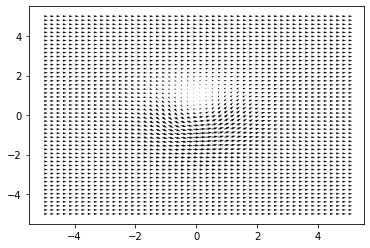

In [6]:
b = 5

_x, _y = np.meshgrid(x, y)
r2 = _x*_x + _y*_y
r = (1-(b*(GAMMA-1))/(8*np.pi*np.pi*GAMMA)*np.exp(1-r2))**(1/(GAMMA-1))
u = 1 - b/(2*np.pi)*np.exp(0.5*(1-r2))*_y
v = b/(2*np.pi)*np.exp(0.5*(1-r2))*_x
p = r**GAMMA

fig, ax = plt.subplots()
q = ax.quiver(x, y, u, v)
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')
plt.show()

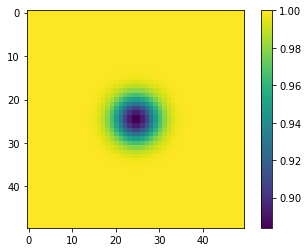

In [7]:
plt.imshow(r)
plt.colorbar()
plt.show()

In [8]:
# no se si esto está bien

boco = Dirichlet({'x': x, 'y': y, 't': np.array([0])}, {'r': r.reshape(-1), 'u': u.reshape(-1), 'v': v.reshape(-1), 'p': p.reshape(-1)}, name='initial', device=device)
pde.add_boco(boco)

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
from nangs import MLP

BATCH_SIZE = 2048
LR = 5e-3
EPOCHS = 100
NUM_LAYERS = 5
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
hist = pde.solve(EPOCHS, BATCH_SIZE)

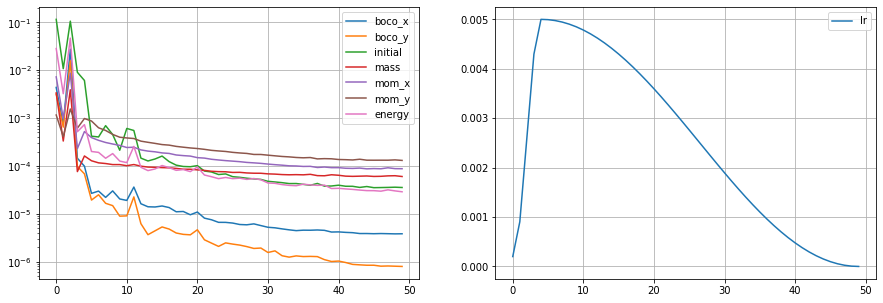

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for name, vale in hist.items():
    if name is not 'lr':
        ax1.plot(hist[name], label=name)
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax2.plot(hist['lr'], label='lr')
ax2.grid(True)
ax2.legend()
plt.show()

In [14]:
# evaluate the solution

x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
t = np.linspace(0,10,40)
eval_mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
outputs = pde.eval(eval_mesh).cpu()
ro = outputs[:, 0].view(len(x),len(y),len(t)).numpy()

In [19]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, t, ro):
    ax.clear()
    ax.imshow(ro[...,i].reshape((len(y),len(x))))
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14, rotation=np.pi/2)
    ax.set_title(f"t = {t[i]:.2f}", fontsize=14)
    return ax

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(t, ro), interval=100)
plt.close()

In [20]:
anim